In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

from generator import UnetGenerator, downsample_layer, upsample_layer, generator_loss, generate_images
from discriminator import PatchDiscriminator, discriminator_loss
import cmp_facades_dataset as facades
from util import random_jitter

/home/jupyter/.keras/datasets/facades/
(1, 128, 128, 3)
(1, 256, 256, 3)


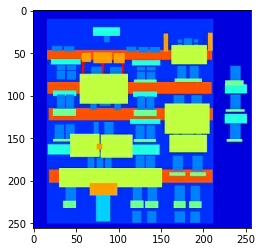

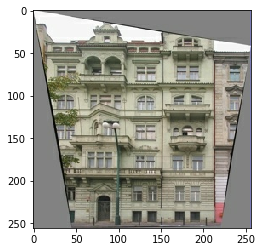

In [2]:
PATH = facades.download_dataset()

BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

print(PATH)

input, real = facades.load_dataset_image(PATH+'train/100.jpg')
plt.figure()
plt.imshow(input / 255.0)
plt.figure()
plt.imshow(real / 255.0)

down_model = downsample_layer(3, 4)
down_result = down_model(tf.expand_dims(input, 0))
print (down_result.shape)

up_model = upsample_layer(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

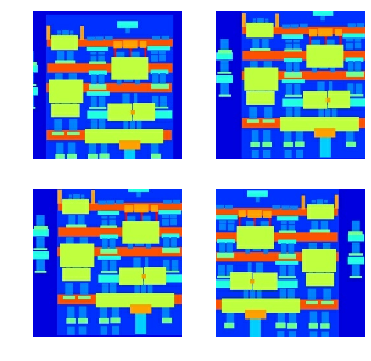

In [3]:
# Random jittering example
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(input, real, IMG_HEIGHT, IMG_WIDTH)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

W0730 13:22:09.186305 139778837927680 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3)
(1, 30, 30, 1)


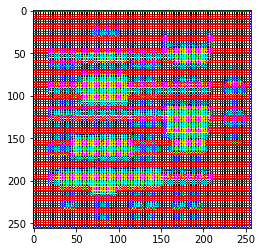

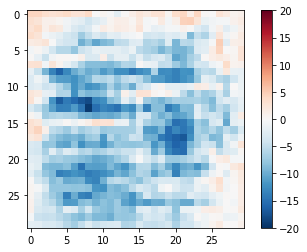

In [4]:
generator = UnetGenerator()
gen_output = generator(input[tf.newaxis,...], training=False)
print(gen_output.shape)
plt.figure()
plt.imshow(gen_output[0,...])

discriminator = PatchDiscriminator()
disc_out = discriminator([input[tf.newaxis,...], gen_output], training=False)
print(disc_out.shape)
plt.figure()
plt.imshow(disc_out[0,:,:,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [5]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [6]:
@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Create G(x), D(x, y), D(x, G(x))
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    # Compute loss
    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Perform gradient descent
  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in dataset:
      train_step(input_image, target)
      print(".", end='')

    clear_output(wait=True)
    for input_image, target in test_dataset.take(1):
      generate_images(generator, input_image, target)

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {}: {}s\n'.format(epoch + 1, time.time() - start))

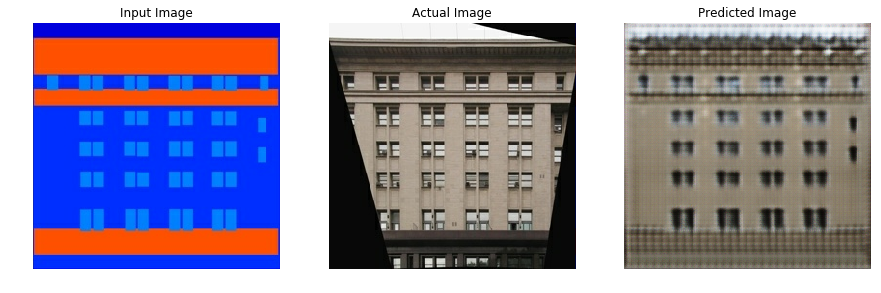

Time taken for epoch 1 is 67.70609951019287 sec



In [8]:
train_dataset, test_dataset = facades.load_dataset(BUFFER_SIZE)
train(train_dataset, 200)